# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
#data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

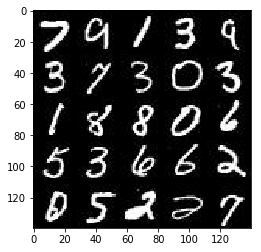

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

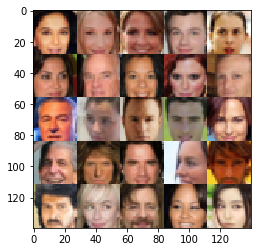

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real=tf.placeholder(tf.float32,shape=(None,image_width,image_height,image_channels),name='inputs_real')
    inputs_z=tf.placeholder(tf.float32,shape=(None,z_dim),name='inputs_z')
    learning_rate=tf.placeholder(tf.float32,name='learnrate')

    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        x1 = tf.maximum(0.2 * x1, x1)
        # 16x16x64
        
        x2 = tf.layers.conv2d(x1, 128, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(0.2 * x2, x2)
        # 8x8x128
        
        x3 = tf.layers.conv2d(x2, 256, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(0.2 * x3, x3)
        # 4x4x256

        # Flatten it
        flat = tf.reshape(x3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
    
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    alpha=0.2
    with tf.variable_scope('generator',reuse= not is_train):
        # First fully connected layer
        
        x1 = tf.layers.dense(z, 2*2*1024)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 2, 2, 1024))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        x1=tf.nn.dropout(x1,0.7)
        # 2x2x1024 now
        #print(x1.shape)
        x2 = tf.layers.conv2d_transpose(x1, 512, 4, strides=2, padding='same')
        #x2 = tf.reshape(x1, (-1, 7, 7, 256))
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha* x2, x2)
        x2=tf.nn.dropout(x2,0.7)
        #print(x2.shape)
        # 4x4x512 now
        
        x3 = tf.layers.conv2d_transpose(x2, 256, 4,strides=1, padding='valid')
        #x2 = tf.reshape(x1, (-1, 7, 7, 256))
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha* x3, x3)
        x3=tf.nn.dropout(x3,0.7)
        #print(x3.shape)
        # 7x7x256 now
        
        x4 = tf.layers.conv2d_transpose(x3, 128, 4, strides=2, padding='same')
        x4 = tf.layers.batch_normalization(x4, training=is_train)
        x4 = tf.maximum(alpha* x4, x4)
        x4=tf.nn.dropout(x4,0.7)
        #print(x4.shape)
        # 14x14x128 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x4, out_channel_dim, 4, strides=2, padding='same')
        #print(logits.shape)
        # 32x32x3 now
        #logits=tf.resh
        
        out = tf.tanh(logits)
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model=generator(input_z,out_channel_dim,True)
    d_model_real,d_logits_real=discriminator(input_real,False)
    d_model_fake,d_logits_fake=discriminator(g_model,reuse=True)
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)*0.9))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars=tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:

def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    inputs_real, inputs_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
           
    d_loss, g_loss = model_loss(inputs_real, inputs_z, data_shape[-1])
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_images = batch_images * 2
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                #print('batch_z shape=',batch_z.shape)
                
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={inputs_real: batch_images, inputs_z: batch_z,lr:learning_rate})
                #print('Hi')
                _ = sess.run(g_opt, feed_dict={inputs_z: batch_z, inputs_real: batch_images,lr:learning_rate})
                _ = sess.run(g_opt, feed_dict={inputs_z: batch_z, inputs_real: batch_images,lr:learning_rate})
                if steps % 10 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({inputs_z: batch_z, inputs_real: batch_images})
                    train_loss_g = g_loss.eval({inputs_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                   

                if steps % 100 == 0:
                    show_generator_output(sess, 25, inputs_z, data_shape[3], data_image_mode)


### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 2.0500... Generator Loss: 0.3971
Epoch 1/2... Discriminator Loss: 1.8782... Generator Loss: 0.5821
Epoch 1/2... Discriminator Loss: 1.7931... Generator Loss: 0.4298
Epoch 1/2... Discriminator Loss: 1.6682... Generator Loss: 0.3847
Epoch 1/2... Discriminator Loss: 1.6825... Generator Loss: 0.3669
Epoch 1/2... Discriminator Loss: 1.0127... Generator Loss: 1.1652
Epoch 1/2... Discriminator Loss: 0.8952... Generator Loss: 2.8416
Epoch 1/2... Discriminator Loss: 1.0141... Generator Loss: 1.8149
Epoch 1/2... Discriminator Loss: 0.9877... Generator Loss: 2.9231
Epoch 1/2... Discriminator Loss: 1.4085... Generator Loss: 2.0299


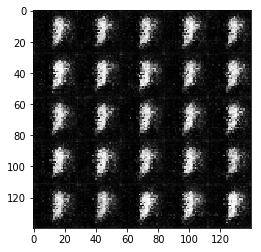

Epoch 1/2... Discriminator Loss: 1.2014... Generator Loss: 2.9505
Epoch 1/2... Discriminator Loss: 0.6970... Generator Loss: 1.7371
Epoch 1/2... Discriminator Loss: 0.7670... Generator Loss: 2.3054
Epoch 1/2... Discriminator Loss: 1.1627... Generator Loss: 1.1748
Epoch 1/2... Discriminator Loss: 0.6323... Generator Loss: 2.3224
Epoch 1/2... Discriminator Loss: 1.2367... Generator Loss: 3.9957
Epoch 1/2... Discriminator Loss: 1.0440... Generator Loss: 0.8657
Epoch 1/2... Discriminator Loss: 0.9104... Generator Loss: 3.1851
Epoch 1/2... Discriminator Loss: 1.3512... Generator Loss: 3.6645
Epoch 1/2... Discriminator Loss: 0.9552... Generator Loss: 2.4129


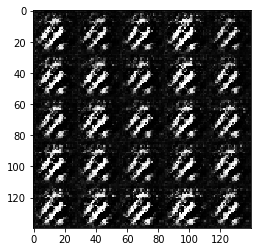

Epoch 1/2... Discriminator Loss: 0.9386... Generator Loss: 2.0297
Epoch 1/2... Discriminator Loss: 1.0330... Generator Loss: 1.4119
Epoch 1/2... Discriminator Loss: 0.8595... Generator Loss: 1.2161
Epoch 1/2... Discriminator Loss: 0.7875... Generator Loss: 1.4587
Epoch 1/2... Discriminator Loss: 1.0030... Generator Loss: 1.1344
Epoch 1/2... Discriminator Loss: 0.9877... Generator Loss: 1.0377
Epoch 1/2... Discriminator Loss: 0.6995... Generator Loss: 1.9167
Epoch 1/2... Discriminator Loss: 0.7442... Generator Loss: 1.4368
Epoch 1/2... Discriminator Loss: 1.0428... Generator Loss: 3.4519
Epoch 1/2... Discriminator Loss: 0.8986... Generator Loss: 1.3442


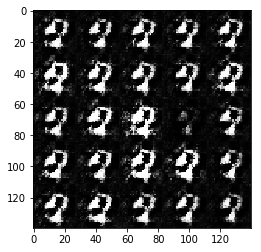

Epoch 1/2... Discriminator Loss: 0.8739... Generator Loss: 1.0824
Epoch 1/2... Discriminator Loss: 0.9990... Generator Loss: 1.0270
Epoch 1/2... Discriminator Loss: 1.6849... Generator Loss: 1.3995
Epoch 1/2... Discriminator Loss: 1.3301... Generator Loss: 0.7982
Epoch 1/2... Discriminator Loss: 1.3578... Generator Loss: 0.5809
Epoch 1/2... Discriminator Loss: 1.2242... Generator Loss: 0.9250
Epoch 1/2... Discriminator Loss: 1.2197... Generator Loss: 0.8353
Epoch 1/2... Discriminator Loss: 1.1286... Generator Loss: 0.9023
Epoch 1/2... Discriminator Loss: 1.4121... Generator Loss: 2.1184
Epoch 1/2... Discriminator Loss: 0.9909... Generator Loss: 1.6459


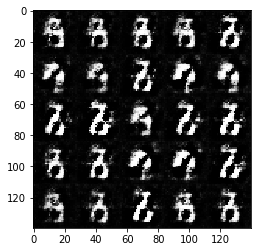

Epoch 1/2... Discriminator Loss: 1.0011... Generator Loss: 1.1581
Epoch 1/2... Discriminator Loss: 1.4676... Generator Loss: 0.5891
Epoch 1/2... Discriminator Loss: 1.1188... Generator Loss: 0.7430
Epoch 1/2... Discriminator Loss: 1.0647... Generator Loss: 1.0145
Epoch 1/2... Discriminator Loss: 1.1183... Generator Loss: 0.7861
Epoch 1/2... Discriminator Loss: 0.8399... Generator Loss: 1.1731
Epoch 1/2... Discriminator Loss: 1.2114... Generator Loss: 0.6691
Epoch 1/2... Discriminator Loss: 0.8169... Generator Loss: 1.4346
Epoch 1/2... Discriminator Loss: 1.2628... Generator Loss: 0.7614
Epoch 1/2... Discriminator Loss: 1.0505... Generator Loss: 0.9638


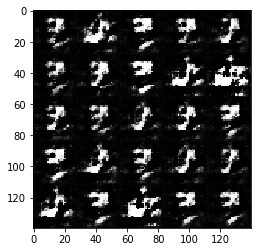

Epoch 1/2... Discriminator Loss: 1.0249... Generator Loss: 1.3544
Epoch 1/2... Discriminator Loss: 0.8945... Generator Loss: 1.2814
Epoch 1/2... Discriminator Loss: 0.9651... Generator Loss: 1.0651
Epoch 1/2... Discriminator Loss: 1.4117... Generator Loss: 0.5212
Epoch 1/2... Discriminator Loss: 1.0929... Generator Loss: 0.9312
Epoch 1/2... Discriminator Loss: 1.2523... Generator Loss: 0.6094
Epoch 1/2... Discriminator Loss: 0.9481... Generator Loss: 1.4995
Epoch 1/2... Discriminator Loss: 0.8754... Generator Loss: 1.1390
Epoch 1/2... Discriminator Loss: 1.0265... Generator Loss: 1.0129
Epoch 1/2... Discriminator Loss: 0.9625... Generator Loss: 0.9308


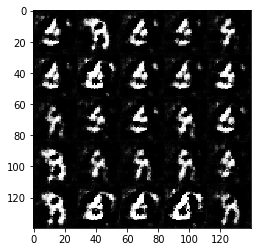

Epoch 2/2... Discriminator Loss: 0.8687... Generator Loss: 1.6741
Epoch 2/2... Discriminator Loss: 0.8152... Generator Loss: 1.9743
Epoch 2/2... Discriminator Loss: 0.7069... Generator Loss: 1.7135
Epoch 2/2... Discriminator Loss: 1.0473... Generator Loss: 2.7258
Epoch 2/2... Discriminator Loss: 1.1579... Generator Loss: 1.8334
Epoch 2/2... Discriminator Loss: 0.8440... Generator Loss: 2.7973
Epoch 2/2... Discriminator Loss: 0.8286... Generator Loss: 1.4362
Epoch 2/2... Discriminator Loss: 0.9867... Generator Loss: 1.2660
Epoch 2/2... Discriminator Loss: 0.9036... Generator Loss: 0.9395
Epoch 2/2... Discriminator Loss: 1.2122... Generator Loss: 0.6626


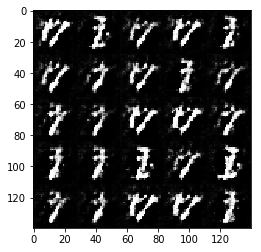

Epoch 2/2... Discriminator Loss: 1.2043... Generator Loss: 0.6872
Epoch 2/2... Discriminator Loss: 0.9444... Generator Loss: 1.0917
Epoch 2/2... Discriminator Loss: 0.9028... Generator Loss: 1.4065
Epoch 2/2... Discriminator Loss: 0.8893... Generator Loss: 1.1744
Epoch 2/2... Discriminator Loss: 1.0024... Generator Loss: 2.0482
Epoch 2/2... Discriminator Loss: 0.9098... Generator Loss: 1.7078
Epoch 2/2... Discriminator Loss: 0.9437... Generator Loss: 2.2178
Epoch 2/2... Discriminator Loss: 1.0375... Generator Loss: 2.1926
Epoch 2/2... Discriminator Loss: 0.8857... Generator Loss: 1.4317
Epoch 2/2... Discriminator Loss: 1.3034... Generator Loss: 1.8911


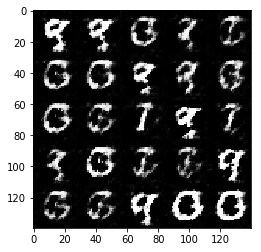

Epoch 2/2... Discriminator Loss: 0.9417... Generator Loss: 1.8584
Epoch 2/2... Discriminator Loss: 0.9016... Generator Loss: 2.2258
Epoch 2/2... Discriminator Loss: 0.8523... Generator Loss: 1.3569
Epoch 2/2... Discriminator Loss: 0.7778... Generator Loss: 2.1338
Epoch 2/2... Discriminator Loss: 1.0095... Generator Loss: 0.9109
Epoch 2/2... Discriminator Loss: 0.9310... Generator Loss: 1.2223
Epoch 2/2... Discriminator Loss: 0.8039... Generator Loss: 1.8619
Epoch 2/2... Discriminator Loss: 1.1389... Generator Loss: 0.8693
Epoch 2/2... Discriminator Loss: 0.9358... Generator Loss: 1.1456
Epoch 2/2... Discriminator Loss: 1.0207... Generator Loss: 1.6420


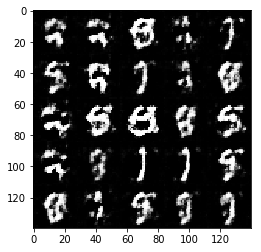

Epoch 2/2... Discriminator Loss: 1.0011... Generator Loss: 2.2453
Epoch 2/2... Discriminator Loss: 1.0771... Generator Loss: 1.3366
Epoch 2/2... Discriminator Loss: 0.9027... Generator Loss: 1.1715
Epoch 2/2... Discriminator Loss: 0.9308... Generator Loss: 1.3012
Epoch 2/2... Discriminator Loss: 1.1780... Generator Loss: 2.5610
Epoch 2/2... Discriminator Loss: 0.9761... Generator Loss: 1.4185
Epoch 2/2... Discriminator Loss: 0.7586... Generator Loss: 1.8244
Epoch 2/2... Discriminator Loss: 0.9962... Generator Loss: 0.9461
Epoch 2/2... Discriminator Loss: 1.1216... Generator Loss: 0.9165
Epoch 2/2... Discriminator Loss: 1.1608... Generator Loss: 0.6284


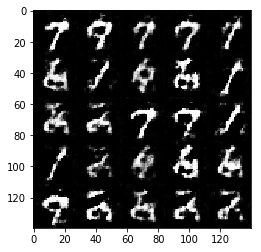

Epoch 2/2... Discriminator Loss: 1.1236... Generator Loss: 0.8853
Epoch 2/2... Discriminator Loss: 1.2534... Generator Loss: 0.5779
Epoch 2/2... Discriminator Loss: 1.1337... Generator Loss: 0.8835
Epoch 2/2... Discriminator Loss: 1.0187... Generator Loss: 0.9796
Epoch 2/2... Discriminator Loss: 0.8280... Generator Loss: 1.9522
Epoch 2/2... Discriminator Loss: 0.9238... Generator Loss: 1.6162
Epoch 2/2... Discriminator Loss: 1.1758... Generator Loss: 1.8702
Epoch 2/2... Discriminator Loss: 0.8092... Generator Loss: 1.8256
Epoch 2/2... Discriminator Loss: 0.9173... Generator Loss: 2.0287
Epoch 2/2... Discriminator Loss: 1.1825... Generator Loss: 1.7116


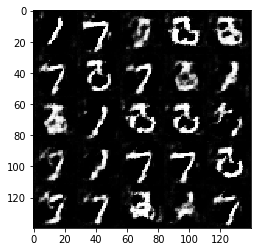

Epoch 2/2... Discriminator Loss: 1.0486... Generator Loss: 1.6908
Epoch 2/2... Discriminator Loss: 1.1579... Generator Loss: 1.9135
Epoch 2/2... Discriminator Loss: 0.8915... Generator Loss: 1.3595
Epoch 2/2... Discriminator Loss: 0.8769... Generator Loss: 1.1931
Epoch 2/2... Discriminator Loss: 1.0736... Generator Loss: 1.0472
Epoch 2/2... Discriminator Loss: 1.0497... Generator Loss: 0.8444
Epoch 2/2... Discriminator Loss: 1.0988... Generator Loss: 0.9695
Epoch 2/2... Discriminator Loss: 0.8963... Generator Loss: 1.0561
Epoch 2/2... Discriminator Loss: 0.9375... Generator Loss: 1.0851
Epoch 2/2... Discriminator Loss: 0.8588... Generator Loss: 1.2008


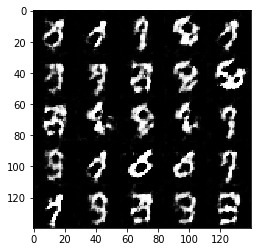

In [14]:
batch_size = 100
z_dim = 100
learning_rate = 0.0001
beta1 = 0.2


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.9730... Generator Loss: 1.1894
Epoch 1/1... Discriminator Loss: 1.8811... Generator Loss: 0.5996
Epoch 1/1... Discriminator Loss: 1.6002... Generator Loss: 0.5452
Epoch 1/1... Discriminator Loss: 1.8757... Generator Loss: 0.3714
Epoch 1/1... Discriminator Loss: 1.9225... Generator Loss: 0.5152
Epoch 1/1... Discriminator Loss: 2.5302... Generator Loss: 2.2717
Epoch 1/1... Discriminator Loss: 1.7401... Generator Loss: 0.8723
Epoch 1/1... Discriminator Loss: 1.1964... Generator Loss: 0.7166
Epoch 1/1... Discriminator Loss: 1.8311... Generator Loss: 1.6668
Epoch 1/1... Discriminator Loss: 1.5262... Generator Loss: 1.3885


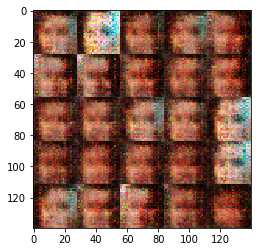

Epoch 1/1... Discriminator Loss: 1.4238... Generator Loss: 0.7028
Epoch 1/1... Discriminator Loss: 1.5838... Generator Loss: 0.6561
Epoch 1/1... Discriminator Loss: 1.6212... Generator Loss: 0.5664
Epoch 1/1... Discriminator Loss: 1.6262... Generator Loss: 1.0844
Epoch 1/1... Discriminator Loss: 1.4813... Generator Loss: 0.7435
Epoch 1/1... Discriminator Loss: 1.4565... Generator Loss: 0.8888
Epoch 1/1... Discriminator Loss: 1.5760... Generator Loss: 0.5845
Epoch 1/1... Discriminator Loss: 1.2609... Generator Loss: 0.8784
Epoch 1/1... Discriminator Loss: 1.4619... Generator Loss: 0.7650
Epoch 1/1... Discriminator Loss: 1.7002... Generator Loss: 0.7436


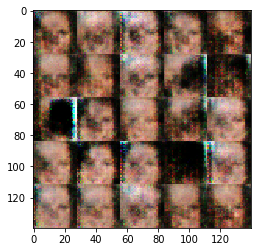

Epoch 1/1... Discriminator Loss: 1.2731... Generator Loss: 0.7466
Epoch 1/1... Discriminator Loss: 1.4640... Generator Loss: 0.9044
Epoch 1/1... Discriminator Loss: 1.4578... Generator Loss: 1.1266
Epoch 1/1... Discriminator Loss: 1.3431... Generator Loss: 0.7139
Epoch 1/1... Discriminator Loss: 1.4566... Generator Loss: 0.7902
Epoch 1/1... Discriminator Loss: 1.4226... Generator Loss: 0.7396
Epoch 1/1... Discriminator Loss: 1.3816... Generator Loss: 0.7811
Epoch 1/1... Discriminator Loss: 1.4180... Generator Loss: 0.7939
Epoch 1/1... Discriminator Loss: 1.3685... Generator Loss: 0.6860
Epoch 1/1... Discriminator Loss: 1.4178... Generator Loss: 0.7903


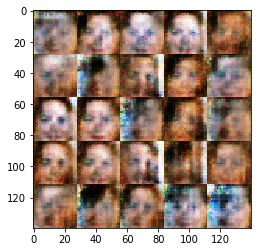

Epoch 1/1... Discriminator Loss: 1.3488... Generator Loss: 0.7829
Epoch 1/1... Discriminator Loss: 1.4353... Generator Loss: 0.8617
Epoch 1/1... Discriminator Loss: 1.4344... Generator Loss: 0.8578
Epoch 1/1... Discriminator Loss: 1.4600... Generator Loss: 0.7436
Epoch 1/1... Discriminator Loss: 1.4172... Generator Loss: 0.5262
Epoch 1/1... Discriminator Loss: 1.4593... Generator Loss: 0.7628
Epoch 1/1... Discriminator Loss: 1.5001... Generator Loss: 0.8663
Epoch 1/1... Discriminator Loss: 1.3898... Generator Loss: 0.7457
Epoch 1/1... Discriminator Loss: 1.4067... Generator Loss: 0.7946
Epoch 1/1... Discriminator Loss: 1.4305... Generator Loss: 0.8376


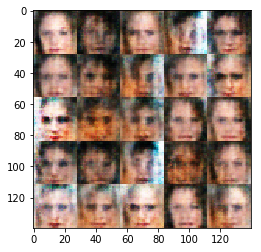

Epoch 1/1... Discriminator Loss: 1.4462... Generator Loss: 0.9778
Epoch 1/1... Discriminator Loss: 1.3709... Generator Loss: 0.8062
Epoch 1/1... Discriminator Loss: 1.4851... Generator Loss: 1.0168
Epoch 1/1... Discriminator Loss: 1.4429... Generator Loss: 0.6970
Epoch 1/1... Discriminator Loss: 1.4266... Generator Loss: 0.7252
Epoch 1/1... Discriminator Loss: 1.4575... Generator Loss: 0.6265
Epoch 1/1... Discriminator Loss: 1.3758... Generator Loss: 0.9975
Epoch 1/1... Discriminator Loss: 1.4597... Generator Loss: 0.8888
Epoch 1/1... Discriminator Loss: 1.4680... Generator Loss: 0.7926
Epoch 1/1... Discriminator Loss: 1.3658... Generator Loss: 0.7728


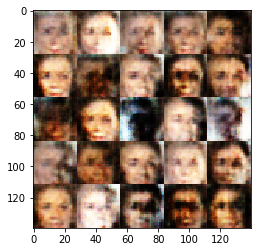

Epoch 1/1... Discriminator Loss: 1.4449... Generator Loss: 0.8299
Epoch 1/1... Discriminator Loss: 1.4524... Generator Loss: 0.7463
Epoch 1/1... Discriminator Loss: 1.4400... Generator Loss: 0.8471
Epoch 1/1... Discriminator Loss: 1.4339... Generator Loss: 0.7627
Epoch 1/1... Discriminator Loss: 1.4385... Generator Loss: 0.8821
Epoch 1/1... Discriminator Loss: 1.4229... Generator Loss: 0.7107
Epoch 1/1... Discriminator Loss: 1.3959... Generator Loss: 0.8201
Epoch 1/1... Discriminator Loss: 1.6533... Generator Loss: 0.6668
Epoch 1/1... Discriminator Loss: 1.3772... Generator Loss: 0.8467
Epoch 1/1... Discriminator Loss: 1.3919... Generator Loss: 0.6713


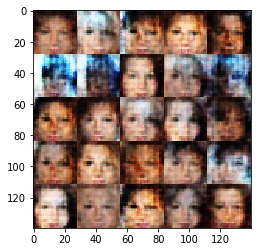

Epoch 1/1... Discriminator Loss: 1.4590... Generator Loss: 0.7645
Epoch 1/1... Discriminator Loss: 1.4670... Generator Loss: 0.7835
Epoch 1/1... Discriminator Loss: 1.4001... Generator Loss: 0.8115
Epoch 1/1... Discriminator Loss: 1.4072... Generator Loss: 0.7960
Epoch 1/1... Discriminator Loss: 1.4319... Generator Loss: 0.7793
Epoch 1/1... Discriminator Loss: 1.4153... Generator Loss: 0.7526
Epoch 1/1... Discriminator Loss: 1.4592... Generator Loss: 0.6988
Epoch 1/1... Discriminator Loss: 1.4021... Generator Loss: 0.7297
Epoch 1/1... Discriminator Loss: 1.4197... Generator Loss: 0.7317
Epoch 1/1... Discriminator Loss: 1.3837... Generator Loss: 0.9060


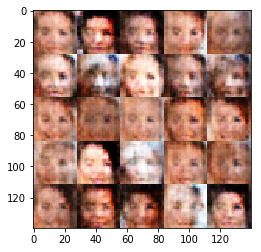

Epoch 1/1... Discriminator Loss: 1.3806... Generator Loss: 0.8473
Epoch 1/1... Discriminator Loss: 1.4680... Generator Loss: 0.8351
Epoch 1/1... Discriminator Loss: 1.4076... Generator Loss: 0.7600
Epoch 1/1... Discriminator Loss: 1.3973... Generator Loss: 0.8757
Epoch 1/1... Discriminator Loss: 1.4119... Generator Loss: 0.7405
Epoch 1/1... Discriminator Loss: 1.4011... Generator Loss: 0.8039
Epoch 1/1... Discriminator Loss: 1.4465... Generator Loss: 0.7378
Epoch 1/1... Discriminator Loss: 1.4156... Generator Loss: 0.7939
Epoch 1/1... Discriminator Loss: 1.4101... Generator Loss: 0.7640
Epoch 1/1... Discriminator Loss: 1.4054... Generator Loss: 0.8330


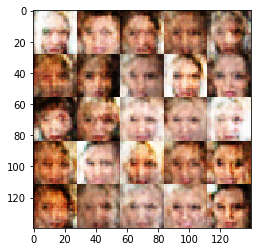

Epoch 1/1... Discriminator Loss: 1.4402... Generator Loss: 0.8071
Epoch 1/1... Discriminator Loss: 1.4834... Generator Loss: 0.8273
Epoch 1/1... Discriminator Loss: 1.3741... Generator Loss: 0.8867
Epoch 1/1... Discriminator Loss: 1.4036... Generator Loss: 0.7399
Epoch 1/1... Discriminator Loss: 1.4005... Generator Loss: 0.8104
Epoch 1/1... Discriminator Loss: 1.4046... Generator Loss: 0.7392
Epoch 1/1... Discriminator Loss: 1.4194... Generator Loss: 0.8089
Epoch 1/1... Discriminator Loss: 1.3983... Generator Loss: 0.7744
Epoch 1/1... Discriminator Loss: 1.3700... Generator Loss: 0.7062
Epoch 1/1... Discriminator Loss: 1.3853... Generator Loss: 0.7958


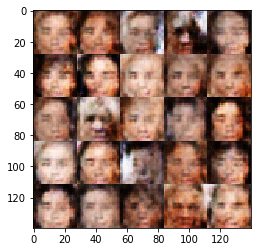

Epoch 1/1... Discriminator Loss: 1.4239... Generator Loss: 0.8959
Epoch 1/1... Discriminator Loss: 1.4145... Generator Loss: 0.7093
Epoch 1/1... Discriminator Loss: 1.4028... Generator Loss: 0.7658
Epoch 1/1... Discriminator Loss: 1.4083... Generator Loss: 0.7759
Epoch 1/1... Discriminator Loss: 1.4228... Generator Loss: 0.7504
Epoch 1/1... Discriminator Loss: 1.4386... Generator Loss: 0.6163
Epoch 1/1... Discriminator Loss: 1.4197... Generator Loss: 0.8282
Epoch 1/1... Discriminator Loss: 1.4205... Generator Loss: 0.7358
Epoch 1/1... Discriminator Loss: 1.4142... Generator Loss: 0.7870
Epoch 1/1... Discriminator Loss: 1.4480... Generator Loss: 0.6096


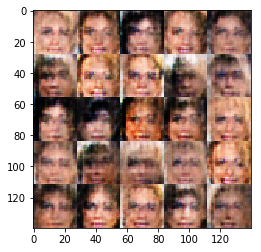

Epoch 1/1... Discriminator Loss: 1.4062... Generator Loss: 0.7191
Epoch 1/1... Discriminator Loss: 1.4031... Generator Loss: 0.7740
Epoch 1/1... Discriminator Loss: 1.4633... Generator Loss: 0.7257
Epoch 1/1... Discriminator Loss: 1.4320... Generator Loss: 0.7890
Epoch 1/1... Discriminator Loss: 1.4528... Generator Loss: 0.7715
Epoch 1/1... Discriminator Loss: 1.4140... Generator Loss: 0.7933
Epoch 1/1... Discriminator Loss: 1.4011... Generator Loss: 0.8606
Epoch 1/1... Discriminator Loss: 1.4155... Generator Loss: 0.7423
Epoch 1/1... Discriminator Loss: 1.3859... Generator Loss: 0.8604
Epoch 1/1... Discriminator Loss: 1.4393... Generator Loss: 0.8030


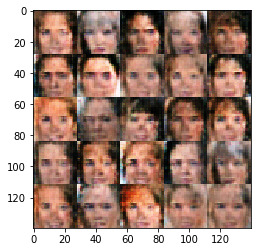

Epoch 1/1... Discriminator Loss: 1.4357... Generator Loss: 0.7285
Epoch 1/1... Discriminator Loss: 1.4047... Generator Loss: 0.7411
Epoch 1/1... Discriminator Loss: 1.4316... Generator Loss: 0.8458
Epoch 1/1... Discriminator Loss: 1.4122... Generator Loss: 0.7401
Epoch 1/1... Discriminator Loss: 1.3818... Generator Loss: 0.6928
Epoch 1/1... Discriminator Loss: 1.3958... Generator Loss: 0.8796
Epoch 1/1... Discriminator Loss: 1.4452... Generator Loss: 0.8188
Epoch 1/1... Discriminator Loss: 1.4107... Generator Loss: 0.6546
Epoch 1/1... Discriminator Loss: 1.4492... Generator Loss: 0.7509
Epoch 1/1... Discriminator Loss: 1.3956... Generator Loss: 0.7937


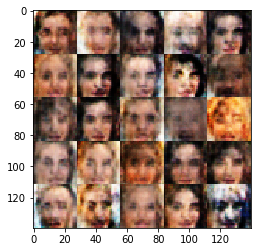

Epoch 1/1... Discriminator Loss: 1.3952... Generator Loss: 0.8525
Epoch 1/1... Discriminator Loss: 1.4439... Generator Loss: 0.7318
Epoch 1/1... Discriminator Loss: 1.4295... Generator Loss: 0.6951
Epoch 1/1... Discriminator Loss: 1.3880... Generator Loss: 0.7849
Epoch 1/1... Discriminator Loss: 1.3856... Generator Loss: 0.7013
Epoch 1/1... Discriminator Loss: 1.4061... Generator Loss: 0.8408
Epoch 1/1... Discriminator Loss: 1.4119... Generator Loss: 0.8303
Epoch 1/1... Discriminator Loss: 1.4180... Generator Loss: 0.7192
Epoch 1/1... Discriminator Loss: 1.3857... Generator Loss: 0.7026
Epoch 1/1... Discriminator Loss: 1.4169... Generator Loss: 0.8112


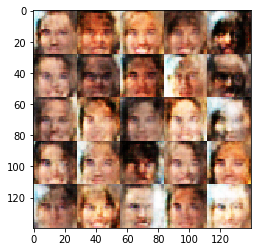

Epoch 1/1... Discriminator Loss: 1.3903... Generator Loss: 0.8165
Epoch 1/1... Discriminator Loss: 1.4127... Generator Loss: 0.7855
Epoch 1/1... Discriminator Loss: 1.3965... Generator Loss: 0.7545
Epoch 1/1... Discriminator Loss: 1.4179... Generator Loss: 0.6993
Epoch 1/1... Discriminator Loss: 1.3926... Generator Loss: 0.7941
Epoch 1/1... Discriminator Loss: 1.4314... Generator Loss: 0.7818
Epoch 1/1... Discriminator Loss: 1.3580... Generator Loss: 0.8687
Epoch 1/1... Discriminator Loss: 1.3947... Generator Loss: 0.8321
Epoch 1/1... Discriminator Loss: 1.4100... Generator Loss: 0.8308
Epoch 1/1... Discriminator Loss: 1.4059... Generator Loss: 0.8128


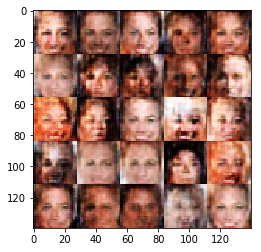

Epoch 1/1... Discriminator Loss: 1.4166... Generator Loss: 0.7047
Epoch 1/1... Discriminator Loss: 1.4198... Generator Loss: 0.7968
Epoch 1/1... Discriminator Loss: 1.4038... Generator Loss: 0.7316
Epoch 1/1... Discriminator Loss: 1.3973... Generator Loss: 0.6516
Epoch 1/1... Discriminator Loss: 1.4051... Generator Loss: 0.7253
Epoch 1/1... Discriminator Loss: 1.4159... Generator Loss: 0.8413
Epoch 1/1... Discriminator Loss: 1.4026... Generator Loss: 0.6764
Epoch 1/1... Discriminator Loss: 1.3998... Generator Loss: 0.8174
Epoch 1/1... Discriminator Loss: 1.4073... Generator Loss: 0.7604
Epoch 1/1... Discriminator Loss: 1.3970... Generator Loss: 0.8289


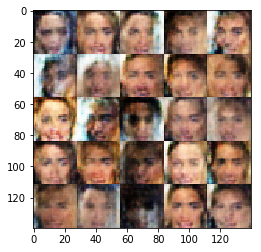

Epoch 1/1... Discriminator Loss: 1.3917... Generator Loss: 0.7818
Epoch 1/1... Discriminator Loss: 1.3886... Generator Loss: 0.8387
Epoch 1/1... Discriminator Loss: 1.4868... Generator Loss: 0.7120
Epoch 1/1... Discriminator Loss: 1.4002... Generator Loss: 0.7985
Epoch 1/1... Discriminator Loss: 1.4298... Generator Loss: 0.8229
Epoch 1/1... Discriminator Loss: 1.4086... Generator Loss: 0.7831
Epoch 1/1... Discriminator Loss: 1.3827... Generator Loss: 0.8401
Epoch 1/1... Discriminator Loss: 1.4131... Generator Loss: 0.7894
Epoch 1/1... Discriminator Loss: 1.4178... Generator Loss: 0.8444
Epoch 1/1... Discriminator Loss: 1.4199... Generator Loss: 0.9008


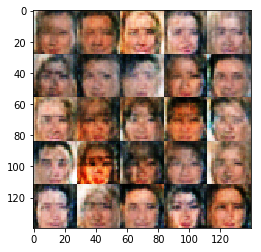

Epoch 1/1... Discriminator Loss: 1.4490... Generator Loss: 0.8317
Epoch 1/1... Discriminator Loss: 1.4289... Generator Loss: 0.8583
Epoch 1/1... Discriminator Loss: 1.3848... Generator Loss: 0.8832
Epoch 1/1... Discriminator Loss: 1.4078... Generator Loss: 0.7753
Epoch 1/1... Discriminator Loss: 1.4286... Generator Loss: 0.6944
Epoch 1/1... Discriminator Loss: 1.3999... Generator Loss: 0.7728
Epoch 1/1... Discriminator Loss: 1.3718... Generator Loss: 0.8034
Epoch 1/1... Discriminator Loss: 1.3715... Generator Loss: 0.7726
Epoch 1/1... Discriminator Loss: 1.3754... Generator Loss: 0.7764
Epoch 1/1... Discriminator Loss: 1.4017... Generator Loss: 0.7756


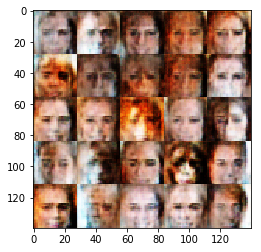

Epoch 1/1... Discriminator Loss: 1.4500... Generator Loss: 0.7688
Epoch 1/1... Discriminator Loss: 1.3979... Generator Loss: 0.7164
Epoch 1/1... Discriminator Loss: 1.4318... Generator Loss: 0.7644
Epoch 1/1... Discriminator Loss: 1.4321... Generator Loss: 0.7493
Epoch 1/1... Discriminator Loss: 1.4068... Generator Loss: 0.7431
Epoch 1/1... Discriminator Loss: 1.3963... Generator Loss: 0.8310
Epoch 1/1... Discriminator Loss: 1.3926... Generator Loss: 0.7493
Epoch 1/1... Discriminator Loss: 1.4199... Generator Loss: 0.8213
Epoch 1/1... Discriminator Loss: 1.4186... Generator Loss: 0.7723
Epoch 1/1... Discriminator Loss: 1.3950... Generator Loss: 0.8466


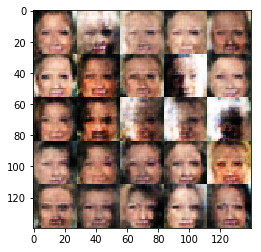

Epoch 1/1... Discriminator Loss: 1.3726... Generator Loss: 0.8575
Epoch 1/1... Discriminator Loss: 1.4214... Generator Loss: 0.8270
Epoch 1/1... Discriminator Loss: 1.3833... Generator Loss: 0.6559
Epoch 1/1... Discriminator Loss: 1.4231... Generator Loss: 0.7272
Epoch 1/1... Discriminator Loss: 1.4086... Generator Loss: 0.9544
Epoch 1/1... Discriminator Loss: 1.3788... Generator Loss: 0.7422
Epoch 1/1... Discriminator Loss: 1.4404... Generator Loss: 0.7861
Epoch 1/1... Discriminator Loss: 1.3792... Generator Loss: 0.7502
Epoch 1/1... Discriminator Loss: 1.4020... Generator Loss: 0.7792
Epoch 1/1... Discriminator Loss: 1.3626... Generator Loss: 0.8314


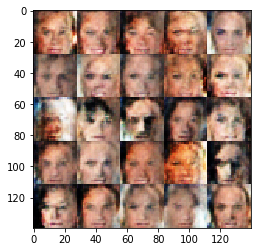

Epoch 1/1... Discriminator Loss: 1.4175... Generator Loss: 0.7866
Epoch 1/1... Discriminator Loss: 1.3993... Generator Loss: 0.8603
Epoch 1/1... Discriminator Loss: 1.3841... Generator Loss: 0.7966
Epoch 1/1... Discriminator Loss: 1.3814... Generator Loss: 0.7516
Epoch 1/1... Discriminator Loss: 1.4109... Generator Loss: 0.8470
Epoch 1/1... Discriminator Loss: 1.3975... Generator Loss: 0.8551
Epoch 1/1... Discriminator Loss: 1.4287... Generator Loss: 0.7519
Epoch 1/1... Discriminator Loss: 1.4182... Generator Loss: 0.6779
Epoch 1/1... Discriminator Loss: 1.3915... Generator Loss: 0.7954
Epoch 1/1... Discriminator Loss: 1.4225... Generator Loss: 0.7133


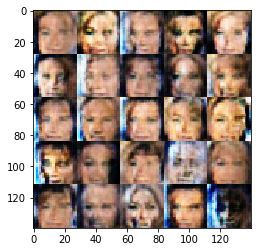

Epoch 1/1... Discriminator Loss: 1.3826... Generator Loss: 0.7533
Epoch 1/1... Discriminator Loss: 1.4064... Generator Loss: 0.8280


In [15]:
batch_size = 100
z_dim = 100
learning_rate = 0.001
beta1 = 0.2


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.